In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

In [38]:
config_file = '../snakemake/config.yml'
with open(config_file) as f:
    config = yaml.safe_load(f)

In [39]:
ab = '../'+expand(config['data']['ab'], species='human')[0]
talon_filt_ab = '../'+expand(config['data']['talon_filt_ab'], species='human')[0]
filt_ab = '../'+expand(config['data']['filt_ab'], species='human')[0]
read_annot = '../'+expand(config['data']['read_annot'], species='human')[0]
t_metadata = '../'+expand(config['ref']['cerberus']['t_info'], species='human')[0]
lib_meta = '../'+expand(config['data']['meta'], species='human')[0]
swan_file = '../'+expand(config['data']['sg'], species='human')[0]
read_lens = '../'+expand(config['data']['read_len_meta'], species='human')[0]
cerberus_h5 = '../'+expand(config['data']['cerb_annot'], species='human')[0]
pi_tpm_table = '../'+expand(config['data']['pi_tpm']['triplet'], species='human', obs_col='biosample')[0]
swan_file = '../'+expand(config['data']['sg'], species='human')[0]
enc_meta_file = '../'+expand(config['data']['enc_meta'], species='human')[0]


sr_ab = '../'+expand(config['sr']['ab'], species='human')[0]


ver = 'v40_cerberus'
min_tpm = 1
gene_subset = 'polya'
obs_col = 'sample'
go_gene_subset = 'protein_coding'

m_lib_meta = '../'+expand(config['data']['meta'], species='mouse')[0]
m_ab = '../'+expand(config['data']['ab'], species='mouse')[0]
m_talon_filt_ab = '../'+expand(config['data']['talon_filt_ab'], species='human')[0]
m_read_annot = '../'+expand(config['data']['read_annot'], species='mouse')[0]
m_t_metadata = '../'+expand(config['ref']['cerberus']['t_info'], species='mouse')[0]
m_swan_file = '../'+expand(config['data']['sg'], species='mouse')[0]

mouse_ver = 'vM25_cerberus'

## Short read gene detection from all samples

Calculating short-read gene TPM values
Subsetting for polya genes
Applying gene type subset
Number of genes reported: 49093
Detected 49093 / 52274 (93.9%) annotated polyA genes
protein_coding
92.13027816690014
   obs_counts  annot_counts
3       18415         19988

lncRNA
53.10457516339869
   obs_counts  annot_counts
4        9425         17748

pseudogene
44.641628834777826
   obs_counts  annot_counts
5        6490         14538



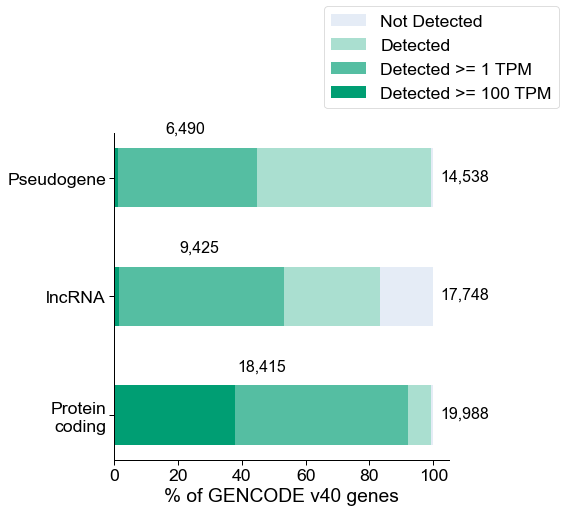

In [5]:
df = pd.read_csv(sr_ab, sep='\t')
plot_gene_det_by_biotype_tpm(df,
                             how='sr',
                             ver=ver,
                             opref='figures/sr_all')

In [6]:
18415/19988

0.9213027816690014

Calculating short-read gene TPM values
Subsetting for protein_coding genes
Enforcing minimum TPM
Total # genes detected: 58780
# genes >= 1 tpm: 38053
Applying gene type subset
Number of genes reported: 18415
Averaging over ENCODE biosample
2370 / 17876 (13.3%) transcripts are expressed in <= 8 samples
13074 / 17876 (73.1%) transcripts are expressed in >= 30 samples
2556 / 17876 (14.3%) transcripts are expressed in < 10% samples
8603 / 17876 (48.1%) transcripts are expressed in > 90% samples
1552 / 17876 (8.7%) transcripts are expressed in < 5% samples
8496 / 17876 (47.5%) transcripts are expressed in > 90% samples


<Figure size 432x432 with 0 Axes>

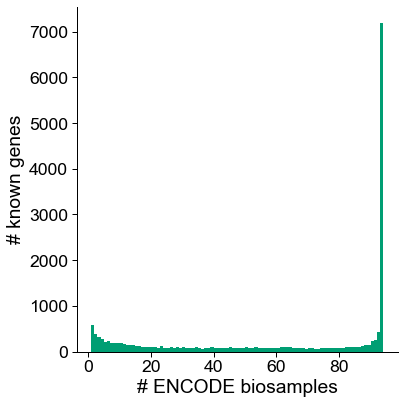

In [7]:
df = pd.read_csv(sr_ab, sep='\t')
df = plot_biosamp_det(df,
                 how='sr',
                 min_tpm=min_tpm,
                 gene_subset='protein_coding',
                 groupby='biosample',
                 opref='figures/sr_all_protein_coding')

specific_thresh = 8
ubiq_thresh = 30

n_iso = len(df.index)
n_specific = len(df.loc[df.n_samples <= specific_thresh].index)
n_ubiq = len(df.loc[df.n_samples >= ubiq_thresh].index)

print('{} / {} ({:.1f}%) transcripts are expressed in <= {} samples'.format(n_specific, n_iso, (n_specific/n_iso)*100, specific_thresh))
print('{} / {} ({:.1f}%) transcripts are expressed in >= {} samples'.format(n_ubiq, n_iso, (n_ubiq/n_iso)*100, ubiq_thresh))

specific_thresh = 10
ubiq_thresh = 90

n_samples = len(df.columns)
df['perc'] = (df.n_samples/n_samples)*100

n_iso = len(df.index)
n_specific = len(df.loc[df.perc < specific_thresh].index)
n_ubiq = len(df.loc[df.perc >ubiq_thresh].index)

print('{} / {} ({:.1f}%) transcripts are expressed in < {}% samples'.format(n_specific, n_iso, (n_specific/n_iso)*100, specific_thresh))
print('{} / {} ({:.1f}%) transcripts are expressed in > {}% samples'.format(n_ubiq, n_iso, (n_ubiq/n_iso)*100, ubiq_thresh))



specific_thresh = 5
ubiq_thresh = 90

n_samples = len(df.columns)
df['perc'] = (df.n_samples/n_samples)*100

n_iso = len(df.index)
n_specific = len(df.loc[df.perc < specific_thresh].index)
n_ubiq = len(df.loc[df.perc >ubiq_thresh].index)

print('{} / {} ({:.1f}%) transcripts are expressed in < {}% samples'.format(n_specific, n_iso, (n_specific/n_iso)*100, specific_thresh))
print('{} / {} ({:.1f}%) transcripts are expressed in > {}% samples'.format(n_ubiq, n_iso, (n_ubiq/n_iso)*100, ubiq_thresh))

## Median number of detected transcripts / protein coding gene

In [9]:
ca = cerberus.read(cerberus_h5)
df = ca.triplets.copy(deep=True)
gene_meta, _, _ = get_gtf_info(how='gene',
                               ver=ver, 
                               add_stable_gid=True)
df = df.merge(gene_meta[['gid_stable', 'biotype_category']],
              how='left',
              left_on='gid',
              right_on='gid_stable')
df = df.loc[df.biotype_category=='protein_coding']

In [24]:
print(df.n_iso.median())
print(df.n_iso.mean())

2.0
3.769517922339085


## How many dominant isoforms? (By ENCODE biosample)

In [45]:
def format_metadata_col(df, col, new_col):
    df[new_col] = df[col].str.lower()
    df[new_col] = df[new_col].str.replace('-', '_')
    df[new_col] = df[new_col].str.replace(' ', '_')
    return df

meta_df = pd.read_csv(enc_meta_file, sep='\t')
meta_df = format_metadata_col(meta_df, 'Biosample term name', 'biosample')
meta_df = meta_df[['Experiment accession', 'biosample']]
meta_df.drop_duplicates(inplace=True)
meta_df.rename({'Experiment accession': 'ENCODE_experiment_id'}, axis=1, inplace=True)

In [46]:
meta_df.head()

,ENCODE_experiment_id,biosample
0,ENCSR435UUS,right_cardiac_atrium
4,ENCSR777CCI,left_ventricle_myocardium_superior
8,ENCSR834DQL,hepg2
24,ENCSR983KDL,k562
32,ENCSR589FUJ,k562


In [47]:
sg = swan.read(swan_file)

Read in graph from ../data/human/swan_graph.p


In [48]:
sg.adata.obs = sg.adata.obs.merge(meta_df,
                                  how='left', 
                                  on='ENCODE_experiment_id')

/Users/fairliereese/miniconda3/envs/base_clone/lib/python3.7/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)
